# Install Required Libraries 

In [1]:
pip install ccxt pandas scikit-learn numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


# Dataset Preparation

# Fetch Historical data

In [2]:
import ccxt
import pandas as pd

def fetch_historical_data(symbol = "BTC/USDT", timeframe="1h", limit=1000):
    exchange = ccxt.binance()
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    return df

# Fetch data
data = fetch_historical_data()
print(data.head())


            timestamp      open      high       low     close       volume
0 2024-11-08 15:00:00  75752.01  76584.60  75636.36  76427.72  4176.027290
1 2024-11-08 16:00:00  76427.72  76514.99  75834.00  75919.30  2102.025720
2 2024-11-08 17:00:00  75919.30  76522.00  75822.07  76385.99  1917.727060
3 2024-11-08 18:00:00  76386.00  76999.00  76342.00  76812.00  2615.869050
4 2024-11-08 19:00:00  76812.00  77199.99  76699.05  76912.58  2811.241873


# Feature Engineering

In [3]:
def add_features(df):
    df['returns'] = df['close'].pct_change()
    df['ma_10'] = df['close'].rolling(window=10).mean()
    df['rsi'] = compute_rsi(df['close'], window=14)
    df.dropna(inplace=True)
    return df

def compute_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data = add_features(data)
print(data.tail())


              timestamp      open      high       low     close      volume  \
995 2024-12-20 02:00:00  96319.99  97731.91  96000.00  97632.59  2632.07757   
996 2024-12-20 03:00:00  97632.59  97784.81  96969.70  97106.02  1041.19363   
997 2024-12-20 04:00:00  97106.02  97838.98  96839.40  97304.07  1275.17255   
998 2024-12-20 05:00:00  97304.07  97491.95  96672.47  96734.32  1339.46566   
999 2024-12-20 06:00:00  96734.33  97050.00  96708.00  96827.38   301.59171   

      returns      ma_10        rsi  
995  0.013627  97586.938  30.504979  
996 -0.005393  97411.954  29.220569  
997  0.002040  97249.088  33.232838  
998 -0.005855  97202.548  32.317779  
999  0.000962  97244.332  32.659528  


# Machine Learning Model

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define target: 1 if price goes up, 0 otherwise
data['target'] = (data['returns'].shift(-1) > 0).astype(int)

# Features and target
features = ['close', 'volume', 'ma_10', 'rsi']
X = data[features]
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Test model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.4797979797979798


# Real-Time Prediction and Trading

In [5]:
def predict_and_trade(latest_data, model):
    features = ['close', 'volume', 'ma_10', 'rsi']
    latest_data = latest_data[-1:]  # Use the latest row for prediction
    prediction = model.predict(latest_data[features])
    
    if prediction[0] == 1:  # Predicted price increase
        print("Buy signal!")
        # Execute buy order (commented for safety)
        # exchange.create_market_buy_order("BTC/USDT", amount=0.001)
    else:
        print("Sell signal or Hold!")

# Simulate real-time data feed
latest_data = add_features(fetch_historical_data(limit=20))
predict_and_trade(latest_data, model)


Buy signal!


# Backtesting

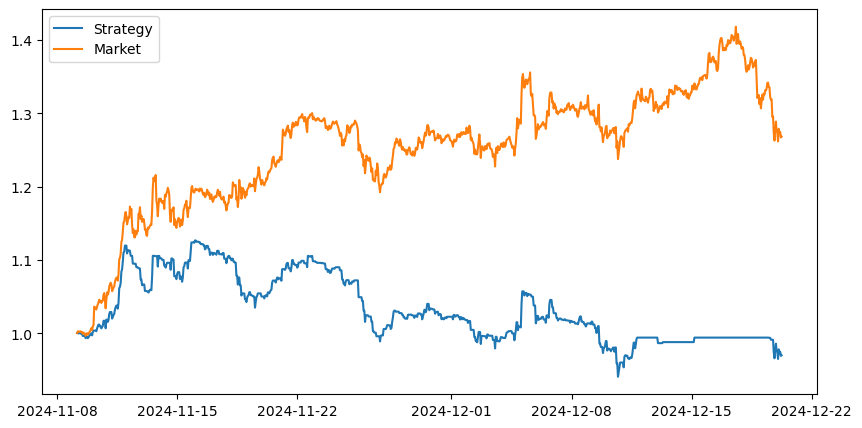

In [6]:
def backtest(data, model):
    data['prediction'] = model.predict(data[features])
    data['strategy_returns'] = data['prediction'] * data['returns']
    cumulative_strategy = (1 + data['strategy_returns']).cumprod()
    cumulative_market = (1 + data['returns']).cumprod()

    # Plot results
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(data['timestamp'], cumulative_strategy, label='Strategy')
    plt.plot(data['timestamp'], cumulative_market, label='Market')
    plt.legend()
    plt.show()

backtest(data, model)


# Dataset Example

In [7]:
import pandas as pd

file_path = r"C:\Users\Admin\Desktop\binance-BTCUSDT-1h.csv"
data = pd.read_csv(file_path, skiprows=1)

# Rename columns and convert timestamp
data.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'ignore']
data['timestamp'] = pd.to_datetime(data['timestamp'])

print(data.head())


                      timestamp        open     high      low    close  \
0 1970-01-01 00:00:01.502946000  1502949599  4308.83  4328.69  4291.37   
1 1970-01-01 00:00:01.502949600  1502953199  4330.29  4345.45  4309.37   
2 1970-01-01 00:00:01.502953200  1502956799  4316.62  4349.99  4287.41   
3 1970-01-01 00:00:01.502956800  1502960399  4333.32  4377.85  4333.32   
4 1970-01-01 00:00:01.502960400  1502963999  4360.00  4445.78  4360.00   

    volume     ignore  
0  4315.32  23.234916  
1  4324.35   7.229691  
2  4349.99   4.443249  
3  4360.69   0.972807  
4  4444.00  10.763623  


# Connect to Binance API

In [8]:
pip install ccxt

# Setting Up the API Connection

In [9]:
import ccxt

# Replace with your Binance API key and secret
API_KEY = "your_api_key_here"
API_SECRET = "your_api_secret_here"

# Initialize Binance exchange object
def connect_binance():
    exchange = ccxt.binance({
        'apiKey': API_KEY,
        'secret': API_SECRET,
        'enableRateLimit': True
    })
    return exchange

# Test connection
exchange = connect_binance()
print("Connected to Binance")

# Fetch account balance
balance = exchange.fetch_balance()
print("Account balance:", balance['total'])


Connected to Binance


AuthenticationError: binance {"code":-2008,"msg":"Invalid Api-Key ID."}

# Fetch Real-Time Market Data

In [ ]:
# Fetch real-time ticker price
def fetch_ticker(exchange, symbol="BTC/USDT"):
    ticker = exchange.fetch_ticker(symbol)
    print(f"Current {symbol} price: {ticker['last']}")
    return ticker

# Fetch OHLCV (Open, High, Low, Close, Volume) data
def fetch_ohlcv(exchange, symbol="BTC/USDT", timeframe="1m", limit=10):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    print(df.tail())
    return df

# Example usage
fetch_ticker(exchange)
fetch_ohlcv(exchange)


# Execute Buy/Sell Orders

In [ ]:
# Execute a market buy order
def place_market_order(exchange, symbol, order_type, amount):
    try:
        if order_type.lower() == "buy":
            order = exchange.create_market_buy_order(symbol, amount)
        elif order_type.lower() == "sell":
            order = exchange.create_market_sell_order(symbol, amount)
        print(f"Order placed: {order}")
    except Exception as e:
        print(f"Error placing order: {e}")

# Example usage
# Buy 0.001 BTC
place_market_order(exchange, symbol="BTC/USDT", order_type="buy", amount=0.001)


# Combine with Prediction Model

In [ ]:
def predict_and_trade(exchange, latest_data, model):
    features = ['close', 'volume', 'ma_10', 'rsi']
    latest_row = latest_data[-1:]  # Use the latest row for prediction
    prediction = model.predict(latest_row[features])
    
    if prediction[0] == 1:  # Predicted price increase
        print("Buy signal detected!")
        place_market_order(exchange, symbol="BTC/USDT", order_type="buy", amount=0.001)
    else:
        print("Sell signal detected!")
        place_market_order(exchange, symbol="BTC/USDT", order_type="sell", amount=0.001)

# Fetch real-time data
latest_data = fetch_ohlcv(exchange, limit=20)
latest_data = add_features(latest_data)

# Use prediction model to trade
predict_and_trade(exchange, latest_data, model)


# Run Continuously

In [ ]:
import time

def run_trading_bot(exchange, model, symbol="BTC/USDT", timeframe="1m"):
    while True:
        try:
            print("Fetching latest data...")
            latest_data = fetch_ohlcv(exchange, symbol=symbol, timeframe=timeframe, limit=20)
            latest_data = add_features(latest_data)
            predict_and_trade(exchange, latest_data, model)
        except Exception as e:
            print(f"Error: {e}")
        
        # Wait before fetching new data
        time.sleep(60)  # 1 minute interval for '1m' timeframe

# Start the bot
run_trading_bot(exchange, model)
